In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid", rc={"figure.figsize": (12, 6)})

def load_clean_country(path: str, country_name: str) -> pd.DataFrame:
    """
    Load a cleaned CSV and add country identifier.
    
    Parameters
    ----------
    path : str
        Relative path to the cleaned CSV file
    country_name : str
        Name of the country (benin, sierraleon, and togo)
    """
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(path, encoding='latin-1')
    
    # Add country column
    df['Country'] = country_name
    
    return df

# Load data for each country
benin = load_clean_country(r'..\data\benin_clean.csv', 'Benin')
sierraleone = load_clean_country(r'..\data/sierraleone_clean.csv', 'sierraleone')
togo = load_clean_country(r'..\data\togo_clean.csv', 'Togo')

# Print the shapes of the loaded DataFrames
print(f"Loaded: Benin {benin.shape}, SierraLeone {sierraleone.shape}, Togo {togo.shape}")

Loaded: Benin (517860, 21), SierraLeone (509308, 21), Togo (516349, 21)


In [52]:
df_all = pd.concat([benin, sierraleone, togo], ignore_index=True)

In [53]:
"""
    Returns
    -------
    pd.DataFrame
        DataFrame with an added 'Country' column and parsed Timestamp.
    """
    # Initialize dictionary to hold country data
df_all = pd.concat([benin, sierraleone, togo], ignore_index=True)
df_all['Timestamp'] = pd.to_datetime(df_all['Timestamp'])
print(f"Combined dataset: {df_all.shape}")

Combined dataset: (1543517, 21)


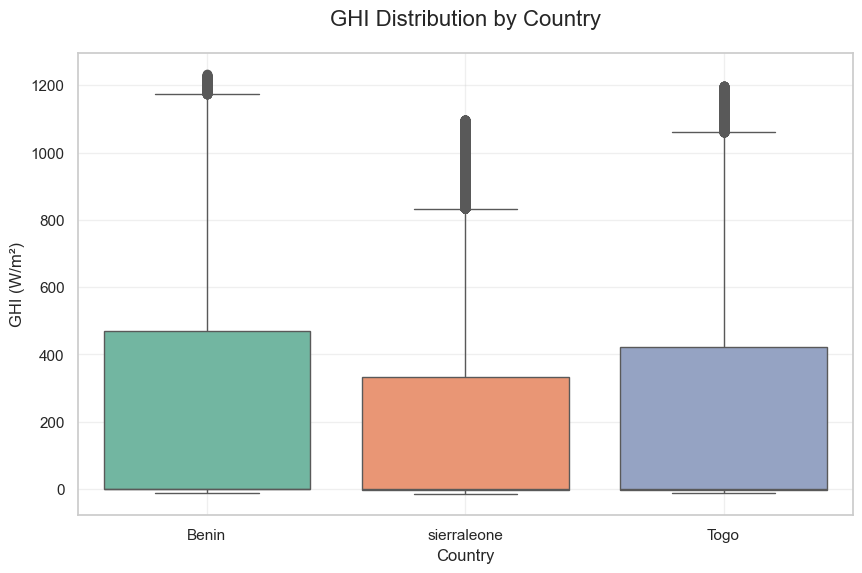

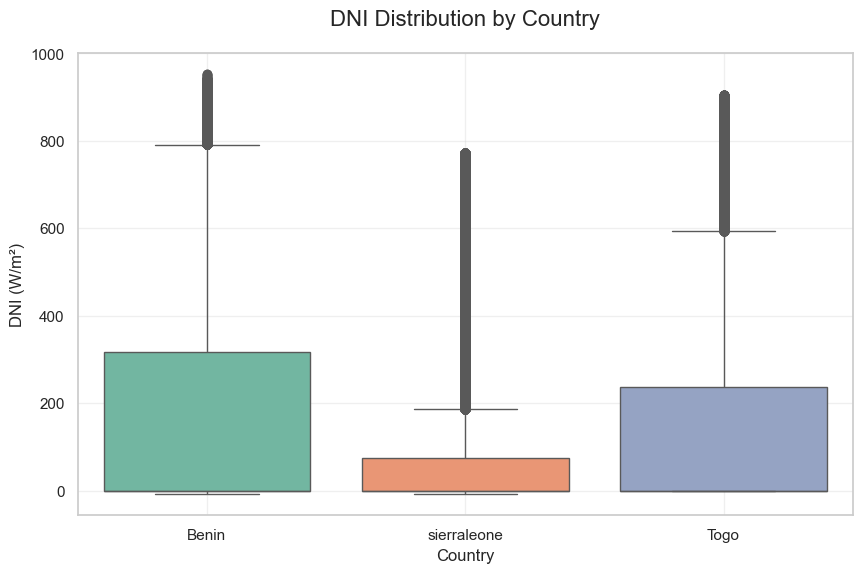

In [54]:
# -----------------------------------------------------
# 3. METRIC COMPARISON – BOXPLOTS
# -----------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_metric_distribution(df: pd.DataFrame, metrics: list) -> None:
    """
    Plot boxplots for given metrics by country.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing solar metrics data, including 'Country' and specified metrics.
    metrics : list
        List of metric names (e.g., 'GHI', 'DNI', 'DHI') to plot.

    Returns
    -------
    None
        This function displays boxplots for each metric.
    """
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='Country', y=metric, palette='Set2')
        plt.title(f'{metric} Distribution by Country', fontsize=16, pad=20)
        plt.ylabel(f'{metric} (W/m²)')
        plt.xlabel('Country')
        plt.grid(True, alpha=0.3)
# Example usage
if __name__ == "__main__":
   
    metrics = ['GHI', 'DNI', 'DHI']
    plot_metric_distribution(df_all, metrics)
     #Show the plots
plt.tight_layout()
plt.savefig('../notebooks/data/benin_graph.png', format='png', dpi=200)
plt.close()
plt.show()

In [55]:
# -----------------------------------------------------
# 4. SUMMARY STATISTICS TABLE
# -----------------------------------------------------

import pandas as pd

def summary_table(df: pd.DataFrame, metrics: list) -> pd.DataFrame:
    """
    Generate a summary statistics table for specified metrics by country.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing solar metrics data, including 'Country' and specified metrics.
    metrics : list
        List of metric names (e.g., 'GHI', 'DNI', 'DHI') for which to calculate statistics.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the mean, median, and standard deviation for each metric by country.
    """
    stats_dict = {}
    
    for country in df['Country'].unique():
        subset = df[df['Country'] == country]
        stats_dict[country] = {
            metric: f"{subset[metric].mean():.1f} ({subset[metric].median():.1f}) ± {subset[metric].std():.1f}"
            for metric in metrics
        }
    
    # Create and return a DataFrame from the statistics dictionary
    return pd.DataFrame(stats_dict).T  # Transpose for better readability

# Example usage
if __name__ == "__main__":
    # Assume df_all is already defined and loaded with the necessary data
    metrics = ['GHI', 'DNI', 'DHI']  # Define which metrics to summarize
    summary = summary_table(df_all, metrics)
    
    # Display the summary table
    print(summary)

                              GHI                   DNI                   DHI
Benin         236.2 (0.7) ± 328.3  166.9 (-0.1) ± 262.1   111.7 (0.5) ± 153.1
sierraleone  185.0 (-0.4) ± 279.0  104.1 (-0.1) ± 201.0  108.1 (-0.6) ± 153.7
Togo          223.9 (0.5) ± 317.3   148.0 (0.0) ± 247.7   112.8 (1.5) ± 151.6


In [56]:
# -----------------------------------------------------
# 5. STATISTICAL TESTING – ANOVA + KRUSKAL-WALLIS
# -----------------------------------------------------

import pandas as pd
from scipy import stats

def statistical_tests(df: pd.DataFrame, metric: str) -> tuple:
    """
    Perform ANOVA and Kruskal-Wallis tests on a specified metric.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing solar metrics data, including 'Country' and the specified metric.
    metric : str
        The name of the metric to test (e.g., 'GHI').

    Returns
    -------
    tuple
        A tuple containing the p-values from the ANOVA and Kruskal-Wallis tests.
    """
    # Group data by country and extract the values for the specified metric
    groups = [group[metric].values for name, group in df.groupby('Country')]
    
    # Perform ANOVA (assumes normal distribution)
    f_stat, p_anova = stats.f_oneway(*groups)
    
    # Perform Kruskal-Wallis (non-parametric test)
    h_stat, p_kruskal = stats.kruskal(*groups)
    
    return p_anova, p_kruskal

# Example usage
if __name__ == "__main__":
    # Assume df_all is already defined and loaded with the necessary data
    ghi_anova, ghi_kruskal = statistical_tests(df_all, 'GHI')
    
    # Display the results
    print(f"GHI – ANOVA p-value: {ghi_anova:.2e}")
    print(f"GHI – Kruskal-Wallis p-value: {ghi_kruskal:.2e}")
    
    # Interpretation of results
    if ghi_anova < 0.05 or ghi_kruskal < 0.05:
        print("→ p < 0.05 → Differences between countries are STATISTICALLY SIGNIFICANT")
    else:
        print("→ p >= 0.05 → No statistically significant differences between countries")

GHI – ANOVA p-value: 0.00e+00
GHI – Kruskal-Wallis p-value: 0.00e+00
→ p < 0.05 → Differences between countries are STATISTICALLY SIGNIFICANT


In [57]:
# -----------------------------------------------------
# 6. RANKING BAR CHART (BONUS)
# -----------------------------------------------------

import matplotlib.pyplot as plt
import pandas as pd

def plot_ranking_bar_chart(df: pd.DataFrame, metric: str) -> None:
    """
    Plot a ranking bar chart for the average values of a specified metric by country.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing solar metrics data, including 'Country' and the specified metric.
    metric : str
        The name of the metric to rank (e.g., 'GHI').

    Returns
    -------
    None
        This function displays a bar chart ranking countries by the specified metric.
    """
    # Calculate mean values and sort them in descending order
    means = df.groupby('Country')[metric].mean().sort_values(ascending=False)

    # Create the bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(means.index, means.values, color=['gold', 'silver', 'chocolate'])
    plt.title(f'Average {metric} Ranking – Recommended Investment Order', fontsize=16, pad=20)
    plt.ylabel(f'Mean {metric} (W/m²)')
    plt.xlabel('Country')

    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Set y-axis limits and display grid
    plt.ylim(0, max(means.values) * 1.15)
    plt.grid(True, axis='y', alpha=0.3)
    
    

# Example usage
if __name__ == "__main__":
    # Assume df_all is already defined and loaded with the necessary data
    plot_ranking_bar_chart(df_all, 'GHI')
# Show the plots
plt.tight_layout()
plt.savefig('../notebooks/data/Compare_countries_graph.png', format='png', dpi=200)
plt.close()
plt.show()

# Key Observations

## Summary of Data
The analysis includes three countries: **Benin**, **Sierra Leone**, and **Togo**, with the following observations:

- **Benin** (n=517,860) shows a mean Global Horizontal Irradiance (GHI) of **236.2 W/m²** with a standard deviation of **328.3**.
- **Sierra Leone** (n=509,308) has a mean GHI of **185.0 W/m²** with a standard deviation of **279.0**.
- **Togo** (n=516,349) records a mean GHI of **223.9 W/m²** with a standard deviation of **317.3**.

The combined dataset includes **1,543,517** records across **21** parameters.

## Statistical Analysis
- **ANOVA p-value for GHI**: `0.00e+00`
- **Kruskal-Wallis p-value for GHI**: `0.00e+00`

Both statistical tests indicate that there are significant differences in GHI among the three countries (p < 0.05).

## Boxplots
The following boxplots illustrate the distribution of GHI and Direct Normal Irradiance (DNI) by country:

### GHI Distribution by Country
![GHI Distribution](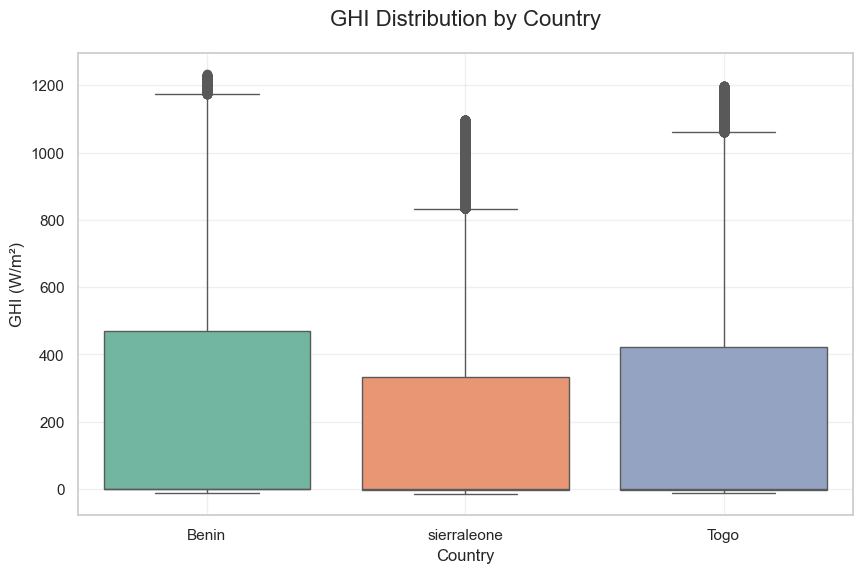)

### DNI Distribution by Country
![DNI Distribution](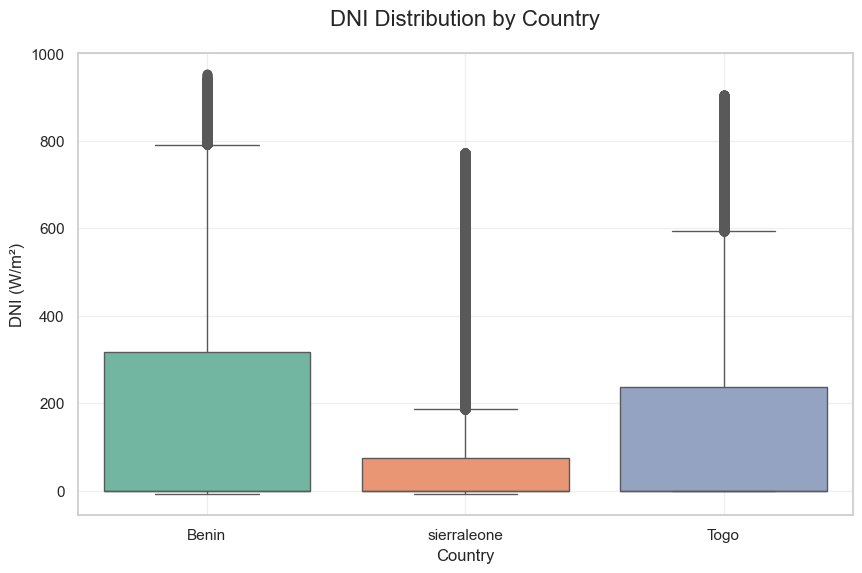)

## Average GHI Ranking
The average GHI rankings highlight the recommended investment order based on solar potential:

![Average GHI Ranking](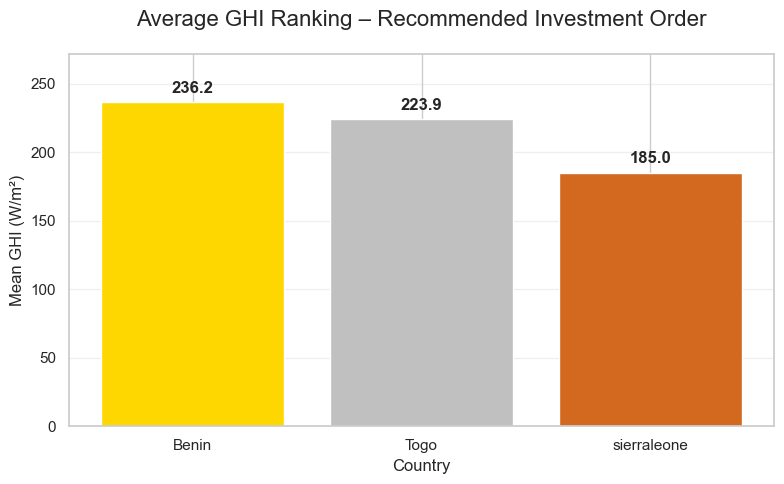)

- **Benin** has the highest mean GHI of **236.2 W/m²**, followed by **Togo** at **223.9 W/m²**, and **Sierra Leone** with the lowest mean GHI of **185.0 W/m²**.

## Conclusions
- The GHI values indicate that **Benin** has the highest mean irradiance, followed by **Togo**, and **Sierra Leone** has the lowest.
- The significant p-values suggest that the differences in GHI among the countries are not due to random chance, indicating meaningful variations in solar potential.
- The boxplots visually reinforce these findings, demonstrating the spread and central tendencies of GHI and DNI across the three countries.
- The average GHI ranking chart further emphasizes the recommended investment order based on GHI, solidifying Benin as the top choice for solar investment.